## Import libraries, load ASR function, unzip dataset, and download model

In [ ]:
!pip install -r requirements.txt

In [2]:
import os
import transformers
import torchaudio
import numpy as np
import sentencepiece
import csv
import pandas as pd

from pyctcdecode import build_ctcdecoder
from transformers import Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, AutoTokenizer, AutoModelForSeq2SeqLM
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

This function performs text generation from audio files in wav format.
It loads the audio file into an array, adjust the sample rate to the one required by the model (16000) and run it into the model that generates text from the waveform.

In [3]:
def asr_model(wav_file, model, processor):
    waveform, sample_rate = torchaudio.load(wav_file)
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
    # Downsampling is required to match the model's frequency, i.e.
    # the frequency of the dataset the model was trained on.
    speech_array = resampler(waveform).squeeze().numpy()
    inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt")['input_values']
    # Detach the tensors first (otherwise, they require gradients
    # to be computed); also, since we're simulating the inference
    # squeeze the resulting array at the first dimension (batch_size),
    # otherwise, leave it as is, and call batch_decode() instead.
    outputs = model(inputs)['logits'].detach().numpy().squeeze(0)
    return(processor.decode(outputs).text)

Download model and processor to be used in the function above.

In [4]:
model = Wav2Vec2ForCTC.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

In [5]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading the LM will be faster if you build a binary file.
Reading /home/studio-lab-user/.cache/pyctcdecode/models--Yehor--wav2vec2-xls-r-300m-uk-with-small-lm/snapshots/bbd936400e7566ba44560440aa4abd05b5983c17/language_model/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


## Prepare dataset

Change directory to the files location. List all the directories in the location to access the files from them.

In [23]:
# Save list of directories in the dataset folder

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/PODROBNOSTY'

folders = os.listdir()
folders = folders[:-1]

/home/studio-lab-user/sagemaker-studiolab-notebooks/PODROBNOSTY


Create a variable to store the file paths and their corresponding transcripts. The variable is a list containing sublists for each pair if path and transcript.
Then, open the file in each directory of the list created before. For each line of the opened file, remove the '/' in the beginning of the line, to keep the path in the appropriate format. In this dataset, the paths and transcripts are separated by two spaces, so a string containing two spaces is used to split the line into a list containing those two elements.

In [24]:
# Open text files in the dataset folders and save each row in a list (splitting the file path and the transcription into an inner list)
text = []
for f in folders:
    file = open(f+'/etc/txt.done.data', 'r', encoding='utf8')
    for line in file:
        line = line.lstrip('/')
        text.append(line.split('  '))

Check if the path and the transcript were splitted correctly by printing the first line. Check if the length of the list matches the size of the dataset (number of wav files).

In [12]:
print(len(text))

1008


In [28]:
print(text[0])

['PODROBNOSTY/16144785683468/wav/spk_id_10704_16144786282442.wav', 'нужденні стали єдиними у бельгії хто має право відвідувати\n', 'нужденні стали єдинами у бельгії хто має право відвідувати']


## Generate text

Change the working directory again to create a csv file that will store all the paths, transcripts, and generated text from the ASR model. First, write a header to the file. Next, the loop calls the function to generate text. The output is saved into a variable that is appended to the list containing the path and transcript for the sentence.
Lastly, the list with all the sentences, containing path + transcript + generated text, is written to the csv file.

In [26]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [27]:
# Save transcription and generated text into a csv file
for i in range(len(text)):
    gen_text = asr_model(text[i][0], model, processor)
    text[i].append(gen_text)

with open('PODROBNOSTY_transcription_generated-text.csv', 'w', encoding='UTF8', newline='\n') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['path', 'transcription', 'generated_text'])

    # write the data
    writer.writerows(text)

## Length Classification

Load the csv containing the wav path, transcript, and generated text as a pandas dataframe.

In [30]:
transcripts = pd.read_csv("PODROBNOSTY_transcription_generated-text.csv", encoding='utf-8')

In [31]:
transcripts.head()

,path,transcription,generated_text
0,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,нужденні стали єдиними у бельгії хто має право...,нужденні стали єдинами у бельгії хто має право...
1,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,щоправда про\n,щоправда мова про
2,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,заклади годують\n,закладе де годують
3,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,лише тих хто\n,лише ти хто
4,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,на це абонемент\n,на це попередній абонемент


To calculate the length difference between the transcript and the generated text, first remove the newline character, if it is present in the transcript. Then, subtract the length of the generated text from the transcript length. Append the result to a list and save the list as a column in the dataframe.

In [32]:
# Calculate length difference between transcripts
length = []
for i in range(len(transcripts['path'])):
    transcripts['transcription'][i] = transcripts['transcription'][i].rstrip('\n')
    length.append(len(transcripts['transcription'][i]) - len(transcripts['generated_text'][i]))

In [33]:
# Create column in dataset
transcripts['length_diff'] = length
transcripts.head()

,path,transcription,generated_text,length_diff
0,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,нужденні стали єдиними у бельгії хто має право...,нужденні стали єдинами у бельгії хто має право...,0
1,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,щоправда про,щоправда мова про,-5
2,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,заклади годують,закладе де годують,-3
3,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,лише тих хто,лише ти хто,1
4,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,на це абонемент,на це попередній абонемент,-11


Based on the difference, classificate each transcript into one of three categories: incomplete (difference is equal or less than -10), inconclusive (difference is equal to or less than -5), or complete (difference is greater than -5). Save the classification as a new column of the dataframe and then save the dataframe as a csv file.

In [34]:
# Classificate transcripts according to length difference

transcripts['length_cat'] = [0 for x in range(1008)]

for i in range(len(transcripts['length_diff'])):
    if transcripts['length_diff'][i] <= -10:
        transcripts['length_cat'][i] = 'incomplete'
    elif transcripts['length_diff'][i] <= -5:
        transcripts['length_cat'][i] = 'inconclusive'
    else:
        transcripts['length_cat'][i] = 'complete'
    

transcripts.to_csv('transcripts_length_cat_PODROBNOSTY.csv', encoding='utf-8')
transcripts.head()

/tmp/ipykernel_428/682401493.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts['length_cat'][i] = 'complete'


,path,transcription,generated_text,length_diff,length_cat
0,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,нужденні стали єдиними у бельгії хто має право...,нужденні стали єдинами у бельгії хто має право...,0,complete
1,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,щоправда про,щоправда мова про,-5,inconclusive
2,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,заклади годують,закладе де годують,-3,complete
3,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,лише тих хто,лише ти хто,1,complete
4,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,на це абонемент,на це попередній абонемент,-11,incomplete


To have a picture about the completeness of the transcripts, count and plot the values in each category.

In [35]:
# Count n of transcripts per category
transcripts['length_cat'].value_counts()

complete        732
incomplete      226
inconclusive     50
Name: length_cat, dtype: int64

<AxesSubplot: >

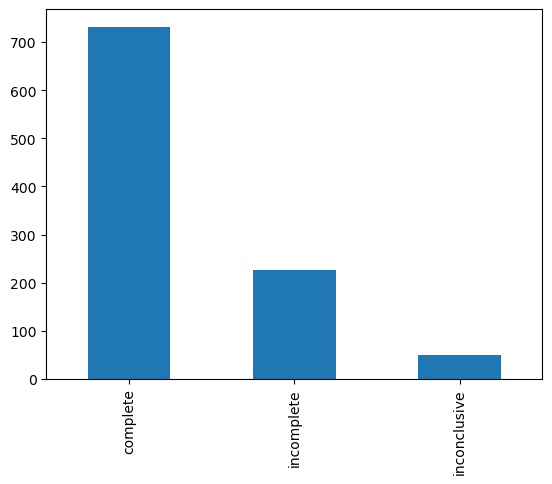

In [36]:
transcripts['length_cat'].value_counts().plot.bar()

Finally, select only the transcripts classificated as incomplete or inconclusive and save them into a text file for manual inspection. The text file contains the path, the transcript, and the generated text, each in a different line, with a blank line separating each sentence.

In [37]:
# Select only transcripts in the incomplete and inconclusive categories
txt = transcripts.loc[(transcripts['length_cat'] == 'incomplete') | (transcripts['length_cat'] == 'inconclusive')]
txt.head()

,path,transcription,generated_text,length_diff,length_cat
1,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,щоправда про,щоправда мова про,-5,inconclusive
4,PODROBNOSTY/16144785683468/wav/spk_id_10704_16...,на це абонемент,на це попередній абонемент,-11,incomplete
6,PODROBNOSTY/16144785683468/wav/spk_id_12228_16...,про не можуть,про найвразливіших бачила олена абрамовичтут н...,-41,incomplete
17,PODROBNOSTY/16144785683468/wav/spk_id_11654_16...,десятків серця,есятків бельгійських хестодюкег дослідно ресто...,-44,incomplete
25,PODROBNOSTY/16144785683468/wav/spk_id_12199_16...,ми між людьми,ми розставили столи щоби між людьми,-22,incomplete


In [39]:
# Save in a text file
with open('transcripts_PODROBNOSTY.txt', 'w', encoding='utf-8') as f:
    for t in range(len(txt)):
        f.write(txt.iloc[t,0]+'\n')
        f.write(txt.iloc[t,1]+'\n')
        f.write(txt.iloc[t,2]+'\n')
        f.write('\n\n')